# Geneformer

If you want to learn more about the method please read the [paper](https://www.nature.com/articles/s41586-023-06139-9).

In [2]:
import anndata as ad
import pickle as pkl
from geneformer_utils import load_mappings
from geneformer import TranscriptomeTokenizer
from geneformer import EmbExtractor


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Use Geneformer to create embeddings of your data
The Geneformer requires ensembl IDs to process the data but we have a function to map this. Example data can be found [here](https://figshare.com/ndownloader/files/42706966)

In [4]:
ann_data = ad.read_h5ad("../../data/10k_pbmcs_proc.h5ad")
# mappings = load_mappings(ann_data.var["gene_symbols"])
mappings = pkl.load(open('./human_gene_to_ensemble_id.pkl', 'rb'))
ann_data.var['ensembl_id'] = ann_data.var['gene_symbols'].apply(lambda x: mappings.get(x,{"id":None})['id'])
ann_data.write_h5ad("./data_genetf/10k_pbmcs_proc_genetf.h5ad")

## Use the Tokenizer

In [5]:
tk = TranscriptomeTokenizer({"cell_type": "cell_type"}, nproc=4)
data_dir = "./data_genetf"
output_dir = "./data_genetf"
output_prefix = "genetransformer"

In [6]:
tk.tokenize_data(data_dir, 
                 output_dir,
                 output_prefix,
                 file_format="h5ad")

Tokenizing data_genetf/10k_pbmcs_proc_genetf.h5ad
data_genetf/10k_pbmcs_proc_genetf.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/opt/homebrew/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Creating dataset.


Saving the dataset (1/1 shards): 100%|██████████| 11990/11990 [00:00<00:00, 440241.83 examples/s]


In [7]:
embex = EmbExtractor(model_type="Pretrained",
                     num_classes=0,
                     filter_data=None,
                     max_ncells=10,
                     emb_layer=0,
                     emb_label=None,
                     labels_to_plot=None,
                     forward_batch_size=5,
                     nproc=4)

In [8]:

embs = embex.extract_embs("/Users/maximeallard/helical/git/Geneformer/geneformer-12L-30M",
                          "/Users/maximeallard/helical/git/helical-package/helical/models/geneformer/data_genetf/genetransformer.dataset",
                          "./data_genetf",
                          "results_emb")

100%|██████████| 2/2 [00:06<00:00,  3.22s/it]


<Axes: xlabel='px', ylabel='py'>

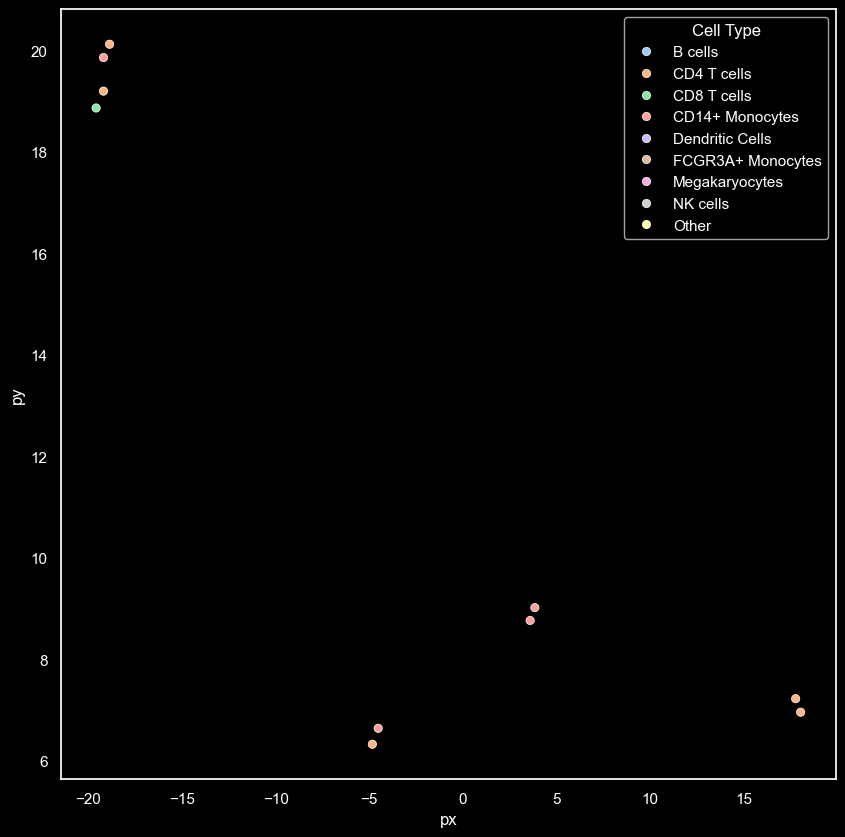

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import pandas as pd

reducer = umap.UMAP(min_dist=0.1, n_components=2, n_epochs=None,n_neighbors=2)
mapper = reducer.fit(embs)

labels = ann_data.obs['cell_type'][:10]
# ax = umap.plot.points(mapper,labels=labels_pf,ax=ax,theme='viridis')

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
plot_df['Cell Type'] = labels.values

plt.figure(figsize=(10,10))
ax = plt.axes()
sns.set_style('dark')
plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=ax,palette="pastel")
